# SIRD implementation using Python



In [107]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
#Loading Dataset 
 
df_cumulative1 = pd.read_csv("1. State Cumulative Data.csv") 
df_cumulative2 = pd.read_csv("2. states.csv") # data cases in different states
df_pop = pd.read_csv("3. population_india_census2011.csv") #population census data

In [109]:
# Storing population of state
state='Maharashtra' #change the country/state/district/city according to what name it 
                    # has in the dataset
    #grabbing out the population of the state from pupulation census data
N = df_pop[df_pop["State / Union Territory"] == state]['Population'][1] 
print('The Population of {0} is {1}'.format(state,int(N)))

The Population of Maharashtra is 112374333


In [110]:
# Performing operations to get the data for State of Maharashtra
df_mh= df_cumulative2[df_cumulative2['State']==state].fillna(0)
df_mh = df_mh.reset_index().drop('index',axis=1)
df_mh

,Date,State,Confirmed,Recovered,Deceased,Other,Tested
0,2020-03-09,Maharashtra,2,0,0,0,0.0
1,2020-03-10,Maharashtra,5,0,0,0,0.0
2,2020-03-11,Maharashtra,11,0,0,0,0.0
3,2020-03-12,Maharashtra,14,0,0,0,0.0
4,2020-03-13,Maharashtra,17,0,0,0,0.0
...,...,...,...,...,...,...,...
158,2020-08-14,Maharashtra,572734,401442,19427,310,3049468.0
159,2020-08-15,Maharashtra,584754,408286,19749,310,3115716.0
160,2020-08-16,Maharashtra,595865,417123,20037,310,3165550.0
161,2020-08-17,Maharashtra,604358,428514,20265,311,3208735.0


## Checking if Total cases are more than  1% of the population


In [111]:
(df_mh['Confirmed'].iloc[162] / N ) *100
#as we can see it is only 0.54% of total population

0.5477024722362535

# Adding Infected,ΔC,ΔD,ΔR,β,δ,γ to dataFrame

I(t) = C(t) – [R(t) + D(t)] The number of Infected (aka active cases) 

ΔC(t) = C(t+1) – C(t) New cases

ΔD(t) = D(t+1) – D(t) Daily deaths

ΔR(t) = R(t+1) - R(t) Daily recoveries

We use the above formulas to calculate the respective variables 

The calculated values are added as columns to our state extracted data 

make sure the column names exist and are typed correctly

In [112]:
# infected
df_mh['Infected'] = df_mh['Confirmed'] - (df_mh["Recovered"] + df_mh['Deceased'])

# delta recovered,delta Confirmed , Delta Dead calculation and addition to table
# tolist() this function converts a dataframe or individual column  to a list
confirmed = df_mh['Confirmed'].tolist() 
deceased = df_mh['Deceased'].tolist()
recovered = df_mh['Recovered'].tolist()
del_c = []
del_d = []
del_r = []
for i in range(len(confirmed)):
    if i == (len(confirmed)-1) : #last values in the table as we dont have data for next day
        c = 0
        d = 0
        r = 0
    else:
        c = confirmed[i+1] - confirmed[i]
        d = deceased[i+1] - deceased[i]
        r = recovered[i+1] - recovered[i]
    del_c.append(c)
    del_d.append(d)
    del_r.append(r)
df_mh['Delta_C'] = del_c
df_mh['Delta_D'] = del_d
df_mh['Delta_R'] = del_r

# beta,gamma and delta Calculation
df_mh['beta'] = (df_mh['Delta_C']/df_mh['Infected']) #*( N/(N-df_mh['Confirmed'])) #if more than 1%
df_mh['gamma'] = df_mh['Delta_R']/df_mh['Infected']
df_mh['delta'] = df_mh['Delta_D']/df_mh['Infected']



In [113]:
df_mh

,Date,State,Confirmed,Recovered,Deceased,Other,Tested,Infected,Delta_C,Delta_D,Delta_R,beta,gamma,delta
0,2020-03-09,Maharashtra,2,0,0,0,0.0,2,3,0,0,1.500000,0.000000,0.000000
1,2020-03-10,Maharashtra,5,0,0,0,0.0,5,6,0,0,1.200000,0.000000,0.000000
2,2020-03-11,Maharashtra,11,0,0,0,0.0,11,3,0,0,0.272727,0.000000,0.000000
3,2020-03-12,Maharashtra,14,0,0,0,0.0,14,3,0,0,0.214286,0.000000,0.000000
4,2020-03-13,Maharashtra,17,0,0,0,0.0,17,9,0,0,0.529412,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2020-08-14,Maharashtra,572734,401442,19427,310,3049468.0,151865,12020,322,6844,0.079149,0.045066,0.002120
159,2020-08-15,Maharashtra,584754,408286,19749,310,3115716.0,156719,11111,288,8837,0.070898,0.056388,0.001838
160,2020-08-16,Maharashtra,595865,417123,20037,310,3165550.0,158705,8493,228,11391,0.053514,0.071775,0.001437
161,2020-08-17,Maharashtra,604358,428514,20265,311,3208735.0,155579,11119,422,9356,0.071469,0.060137,0.002712


# adding r0 and R
 r0 = β – (γ + δ)   this is  the (per capita) growth rate per day
 
  R0 = β/(γ + δ)    this is the basic reproductive number

In [114]:
df_mh['r0'] = df_mh['beta'] - (df_mh['gamma'] + df_mh['delta'])
df_mh['R0'] = df_mh['beta'] / (df_mh['gamma'] + df_mh['delta'])


In [115]:
# replacing infinite values with zero as R0 has division with zero 
# which resulted in infinte values
df_mh = df_mh.replace([np.inf, -np.inf], np.nan)
df_mh = df_mh.fillna(0)

In [116]:
df_mh

,Date,State,Confirmed,Recovered,Deceased,Other,Tested,Infected,Delta_C,Delta_D,Delta_R,beta,gamma,delta,r0,R0
0,2020-03-09,Maharashtra,2,0,0,0,0.0,2,3,0,0,1.500000,0.000000,0.000000,1.500000,0.000000
1,2020-03-10,Maharashtra,5,0,0,0,0.0,5,6,0,0,1.200000,0.000000,0.000000,1.200000,0.000000
2,2020-03-11,Maharashtra,11,0,0,0,0.0,11,3,0,0,0.272727,0.000000,0.000000,0.272727,0.000000
3,2020-03-12,Maharashtra,14,0,0,0,0.0,14,3,0,0,0.214286,0.000000,0.000000,0.214286,0.000000
4,2020-03-13,Maharashtra,17,0,0,0,0.0,17,9,0,0,0.529412,0.000000,0.000000,0.529412,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2020-08-14,Maharashtra,572734,401442,19427,310,3049468.0,151865,12020,322,6844,0.079149,0.045066,0.002120,0.031963,1.677365
159,2020-08-15,Maharashtra,584754,408286,19749,310,3115716.0,156719,11111,288,8837,0.070898,0.056388,0.001838,0.012672,1.217644
160,2020-08-16,Maharashtra,595865,417123,20037,310,3165550.0,158705,8493,228,11391,0.053514,0.071775,0.001437,-0.019697,0.730958
161,2020-08-17,Maharashtra,604358,428514,20265,311,3208735.0,155579,11119,422,9356,0.071469,0.060137,0.002712,0.008619,1.137145


# Smoothing beta gamma and delta.

#### As the original data has  noise in it we need to smooth data

Smoothing beta and delta with a fraction of 0.1 and 
gamma with fraction of 0.2


The LOWESS fraction controls the smoothness of the curve. For example, if it is 1.0, then the LOWESS curve is a single straight line. In general, the smaller the fraction, the more that LOWESS curve follows individual data points.

In [117]:
#this is our smoothing Function
from statsmodels.nonparametric.smoothers_lowess import lowess
def smooth(df,col,fraction):

    df_lowess = pd.DataFrame(lowess(df[col],
                                 np.arange(len(df[col])), 
                                 frac=fraction)[:, 1], index=df.index, 
                                  columns=[col])
    return df_lowess

we smooth the data only after C(t) exceeds 100 cases and use a constant for the period before, set equal to the first smoothed estimate. 

For this we look at our data and find out when the cases exceed 100,

from that point in time onwards we smooth delta,beta and gamma

The points before when Confirmed > 100,are all set to the first smoothed estimate

In [118]:
df_sm = df_mh.drop(list(range(15)))
df_smooth = smooth(df_sm,'beta',0.1)
df_smooth['gamma'] = smooth(df_sm,'gamma',0.2)
df_smooth['delta'] = smooth(df_sm,'delta',0.1)


In [119]:
#smoothed values of beta gamma and delta
df_smooth

,beta,gamma,delta
15,0.150157,-0.000259,0.000127
16,0.155035,0.000534,0.001640
17,0.159566,0.001315,0.003150
18,0.163944,0.002081,0.004660
19,0.168503,0.002833,0.006179
...,...,...,...
158,0.073554,0.065300,0.002048
159,0.071939,0.065129,0.001980
160,0.070153,0.064928,0.001905
161,0.068173,0.064701,0.001822


In [120]:
# the cases cross 100 at 2020-03-24 the index 15 in our table
# before that all values are equal to the first smoothed estimate
for i in range(-1,-16,-1):
    df_smooth.loc[i] = [0.150157,-0.000259 ,0.000127]
    
df_smooth.index = df_smooth.index + 15  # shifting index
df_smooth = df_smooth.sort_index()    
df_smooth = df_smooth.reset_index()
df_smooth = df_smooth.drop('index',axis=1)

In [121]:
# Adding smoothed r0 to the smoothed data
df_smooth['r0'] = df_smooth['beta'] - df_smooth['delta'] - df_smooth['gamma']
df_smooth

,beta,gamma,delta,r0
0,0.150157,-0.000259,0.000127,0.150289
1,0.150157,-0.000259,0.000127,0.150289
2,0.150157,-0.000259,0.000127,0.150289
3,0.150157,-0.000259,0.000127,0.150289
4,0.150157,-0.000259,0.000127,0.150289
...,...,...,...,...
158,0.073554,0.065300,0.002048,0.006206
159,0.071939,0.065129,0.001980,0.004830
160,0.070153,0.064928,0.001905,0.003320
161,0.068173,0.064701,0.001822,0.001650


# The equations on which our model is defined

S(t+1) = S – βSI/N

I(t+1) = I + βSI/N – γI – δI

R(t+1) = R + γI

D(t+1) = D + δI

S:Susceptible , I:Infected , R:Recovered , D:Deceased

In [122]:
#defined model of SIRD
def SIRD(S,I,R,D,df_smooth):
    s_ , i_ , r_ , d_ = [],[],[],[]
    for i in range(len(df_smooth)):
        S = S - (df_smooth.loc[i]['beta']*S*I)/N
        I = I + ((df_smooth.loc[i]['beta']*S*I)/N) \
             - df_smooth.loc[i]['gamma']*I - df_smooth.loc[i]['delta']*I
        R = R + df_smooth.loc[i]['gamma']*I
        D = D + df_smooth.loc[i]['delta']*I
        s_.append(S)
        i_.append(I)
        r_.append(R)
        d_.append(D)
    df = pd.DataFrame(columns=['Susceptible','Confirmed','Infected','Recovered','Deceased'])
    df['Susceptible'] = s_
    df['Infected']    = i_
    df['Recovered']   = r_
    df['Deceased']    = d_
    df['Confirmed']   = df['Infected'] + df['Recovered'] + df['Deceased']
    
    return df
    
    

# Defining initial values for our SIRD model
### S(0) = N ,D(0)=R(0)=0
###  C = I + R + D


For I(0) must be determined from the data .


In [138]:
S = N
I = 11
R = 0
D = 0

In [139]:
S,I,R,D

(112374333, 11, 0, 0)

In [140]:
df_pred = SIRD(S,I,R,D,df_smooth)

In [141]:
df_pred['Confirmed'][162]

629951.6482652578

# Measure of Model Fit 
## predR² = 1 – Σ(Y – X)2 / Σ[X – mean(X)]2

we use numer = Σ(Y – X)2 and denom = Σ[X – mean(X)]2



In [142]:
def PredR_sq(df_pred,df_orig,col):
    '''col represents the column on which predR_squared will be applied'''
    
    n = (df_pred[col] - df_orig[col])**2 
    numer = n.sum() #summation
    mean_x = df_orig[col].mean()
    d = (df_orig[col] - mean_x)**2
    denom = d.sum() #summation
    pred_rsq = 1 - (numer/denom)
    
    return pred_rsq

In [143]:
# pass in column name on which we need to measure the 
print(PredR_sq(df_pred,df_mh,'Confirmed'))

0.995427556069006


# Plots

predicted vs Original 

Scattered are the original datapoints

Curves or lines are the predicted datapoints

#### Here ax.scatter plots the scatter plot 

first and second arguements are x and y axis data respectively

s represents the size of individual marker

#### ax.plot is used to plot the curve of predicted values

first and second arguements are x and y axis data

linewidth can be modified by changing the value

#### xticks are used to control labels on x axis

the dates at index 0 40 80 120 160 are only displayed as labels



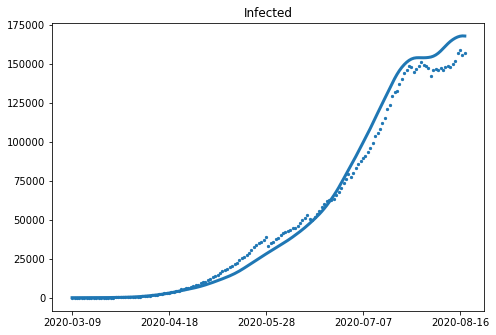

In [154]:
#infected
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_mh['Date'],df_mh['Infected'],s=5)
ax.plot(df_mh['Date'],df_pred['Infected'],linewidth=3)
ax.set_xticks([0,40,80,120,160])
ax.set_title('Infected')
# plt.savefig('Infected.jpg',bbox_inches='tight') #uncomment if want to save the graph as image
plt.show()


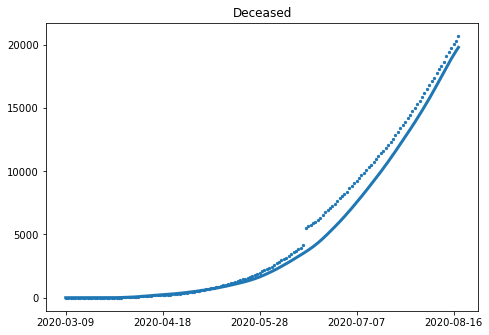

In [145]:
#Deceased
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_mh['Date'],df_mh['Deceased'],s=5)
ax.plot(df_mh['Date'],df_pred['Deceased'],linewidth=3)
ax.set_xticks([0,40,80,120,160])
ax.set_title('Deceased')
#plt.savefig('Deceased.jpg',bbox_inches='tight') #uncomment if want to save the graph as image
plt.show()


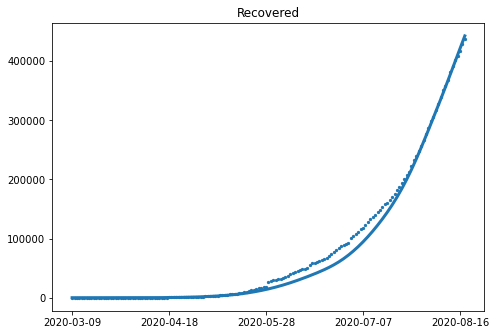

In [146]:
#Recovered
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_mh['Date'],df_mh['Recovered'],s=5)
ax.plot(df_mh['Date'],df_pred['Recovered'],linewidth=3)
ax.set_xticks([0,40,80,120,160])
ax.set_title('Recovered')
#plt.savefig('Recovered.jpg',bbox_inches='tight') #uncomment if want to save the graph as image
plt.show()

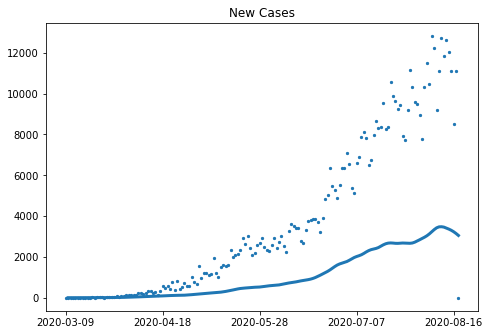

In [132]:
#New Cases deltaC
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_mh['Date'],df_mh['Delta_C'],s=5)
ax.plot(df_mh['Date'],df_pred['Confirmed'].diff(),linewidth=3)
ax.set_xticks([0,40,80,120,160])
ax.set_title('New Cases')
#plt.savefig('New Cases.jpg',bbox_inches='tight') #uncomment if want to save the graph as image
plt.show()

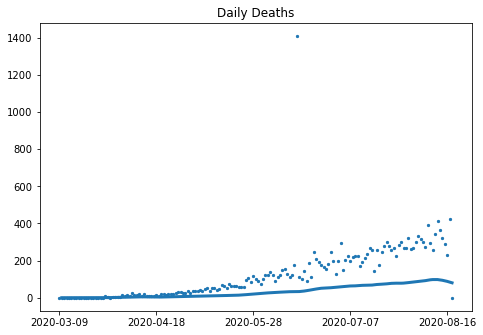

In [133]:
#Daily deaths delta_D
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_mh['Date'],df_mh['Delta_D'],s=5)
ax.plot(df_mh['Date'],df_pred['Deceased'].diff(),linewidth=3)
ax.set_xticks([0,40,80,120,160])
ax.set_title('Daily Deaths')
#plt.savefig('Daily Deaths.jpg',bbox_inches='tight') #uncomment if want to save the graph as image
plt.show()


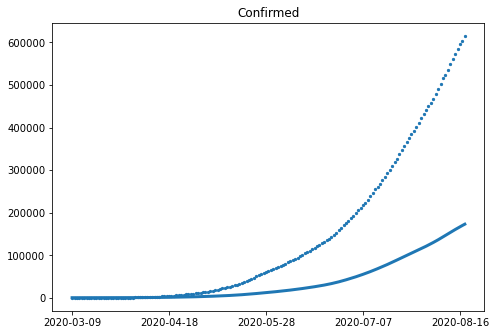

In [134]:
#Confirmed
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.scatter(df_mh['Date'],df_mh['Confirmed'],s=5)
ax.plot(df_mh['Date'],df_pred['Confirmed'],linewidth=3)
ax.set_xticks([0,40,80,120,160])
ax.set_title('Confirmed')
#plt.savefig('Confirmed.jpg',bbox_inches='tight') #uncomment if want to save the graph as image
plt.show()


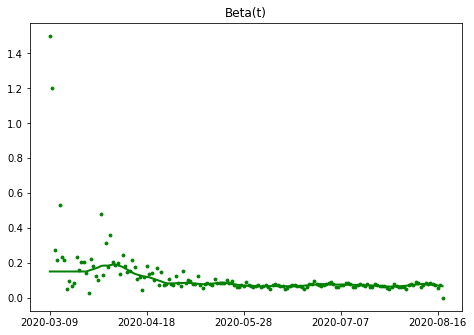

In [135]:
#beta
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.scatter(df_mh['Date'],df_mh['beta'],s=8,c='g')
ax.plot(df_mh['Date'],df_smooth['beta'],linewidth=2,c='g')
ax.set_xticks([0,40,80,120,160])
ax.set_title('Beta(t)')
#plt.savefig('Beta.png',bbox_inches='tight') #uncomment if want to save the graph as image
plt.show()


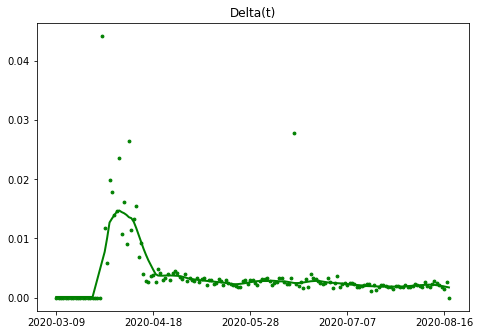

In [136]:
#Delta
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.scatter(df_mh['Date'],df_mh['delta'],s=8,c='g')
ax.plot(df_mh['Date'],df_smooth['delta'],linewidth=2,c='g')
ax.set_xticks([0,40,80,120,160])
ax.set_title('Delta(t)')
#plt.savefig('Delta.jpg',bbox_inches='tight')#uncomment if want to save the graph as image
plt.show()


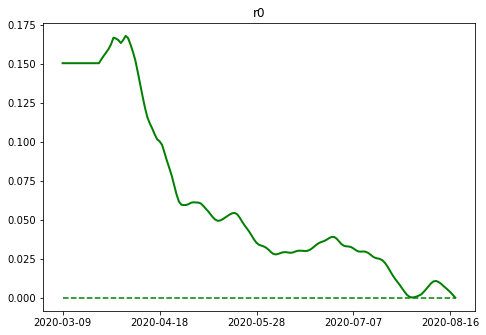

In [137]:
#Delta
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(df_mh['Date'],[0]*163,'--g')
ax.plot(df_mh['Date'],df_smooth['r0'],linewidth=2,c='g')
ax.set_xticks([0,40,80,120,160])
ax.set_title('r0')
#plt.savefig('r0.jpg',bbox_inches='tight') #uncomment if want to save the graph as image
plt.show()